# Toxic Comment Classification
By Andrew Watkins

## Table of Contents

1. [Introduction](#introduction)
2. [The Data](#data)    
    - [File Description](#file)
3. [Data Wrangling](#wrangling)
4. [Exploratory Data Analysis](#eda)
    * [Tags](#tags)
    * [Comment Analyis](#com_analysis)
5. [Clean the Comments](#clean)
6. [Word Count](#count)
7. [Word Frequency with Word Cloud](#wordcloud)
8. [Creating the Models](#models)
    * [Naive Bayes](#mnb)
    * [Logistic Regression](#log)
    * [Binary Relevance](#binary)
    * [Classifier Chains](#chain)
9. [Conclusion](#conclusion)
    * [Verify the model](#verify)
    * [Export Model](#export)

# <a name="introduction"></a>Introduction
---

Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. Current models don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content). The goal is to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate. This model will be used as an API which can be used to predict comments at will. 

# <a name="data"></a>The Data
---

The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate


### <a name="file"></a> File description

* **train.csv** - contains comments with their binary labels

# <a name="wrangling"></a>Data Wrangling
---

In this section I am going to load the dataset and look at the columns and some basic DataFrame info.

In [1]:
import pandas as pd

In [2]:
#declare the path of the data
test_data_location = 'data/test.csv'
train_data_location = 'data/train.csv'

#import the data as a DataFramae with 'id' as the index
df = pd.read_csv(train_data_location, index_col='id')

In [3]:
#Look at some values in the train DF
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#look at the info of the train DF and its columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [5]:
#fill in any null values
df["comment_text"].fillna("unknown", inplace=True)

Now I will create a new DF that will hold stats on the comments such as word counts. This DF will be used later to do some EDA on the comments. This is done before we clean the comments because some features such as puntuation and stopwords will be removed.

# <a name="eda"></a>Exploratory Data Analysis
---

Now that the data is loaded I need to do some EDA. I am going to first look at the tags and then the comments themselves. 

## <a name="tags"></a>Tag Analysis
---

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
count_labels = df.iloc[:,1:].sum()
print(count_labels)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [8]:
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(df))

Total tags:  35098
Total comments:  159571


Not all comments have been tagged with one of the available tags, this indicates that the comment is not toxic. I am going to create a new column to tag these comments. 

In [9]:
#add up the tags for each comment.
rowsums = df.iloc[:,1:].sum(axis=1)

#if the comment has no tags then it is non-toxic
df['non_toxic'] = (rowsums==0) #is there a way to add it as 1 or 0 off the bat?

#convert the boolean column to 1 or 0
df = df.applymap(lambda x: 1 if x == True else x)
df = df.applymap(lambda x: 0 if x == False else x)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [10]:
#update the count labels
count_labels = df.iloc[:,1:].sum()
count_labels = count_labels.sort_values()
print(count_labels*100/len(df))

threat            0.299553
identity_hate     0.880486
severe_toxic      0.999555
insult            4.936361
obscene           5.294822
toxic             9.584448
non_toxic        89.832112
dtype: float64


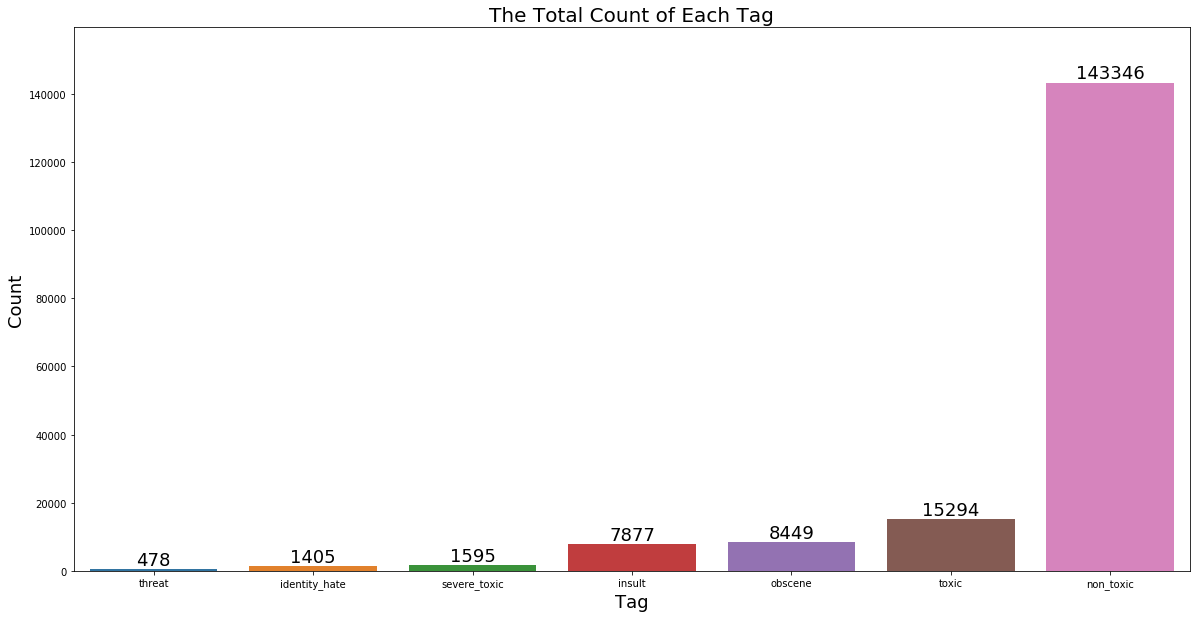

In [11]:
#plot the total to have a better look
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(count_labels.index, count_labels.values)
plt.title("The Total Count of Each Tag", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Tag', fontsize=18)
plt.ylim(0,len(df))

#add the count to the tags
rects = ax.patches
labels = count_labels.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

In [12]:
#Check the total tags and comments again
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(df))

Total tags:  178444
Total comments:  159571


There are more tags than total comments, this is most likely due to some comments having multiple tags. I will double check this now.

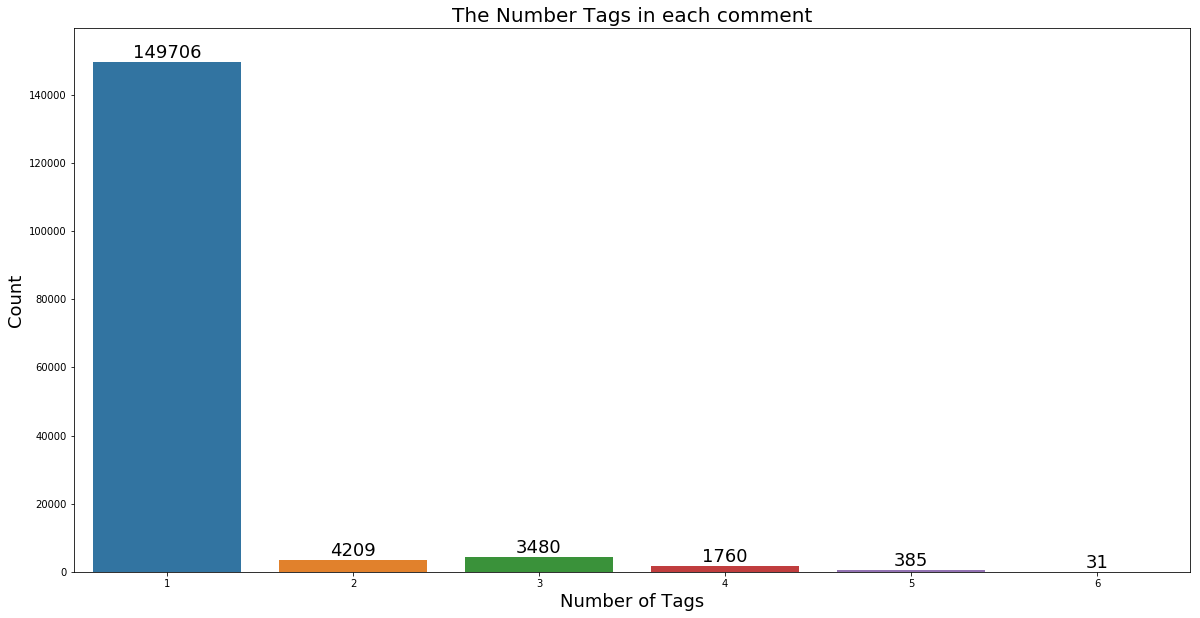

In [13]:
#plot the total count of each 
tag_count = df.iloc[:,1:].sum(axis=1).value_counts()
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(tag_count.index, tag_count.values)
plt.title("The Number Tags in each comment", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Number of Tags', fontsize=18)
plt.ylim(0,len(df))

#adding the text labels
rects = ax.patches
labels = tag_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

Indeed there are a lot of comments that have several tags.

## <a name="com_analysis"></a> Comment Analysis
---
Now in this section I am going to explore the comments themselves. To do this I am going to create a new DataFrame in which I am going to store the statistcs of each comments. The stats I am going to gather are the following:
1. sentence count
2. word count
3. unique word count
4. letter count
5. punctuation count
6. upper word count
7. title word count
8. stopwords count
9. mean word length
10. unique word percentage
11. punctuation percentage

In [14]:
#import required packages
import re as regex
import string
import numpy as np
import matplotlib.gridspec as gridspec 

import nltk
from nltk.corpus import stopwords

eng_stopwords = set(stopwords.words("english"))

In [15]:
#Create the DF
stats_df = df.iloc[:,1:]

#Sentense count
stats_df['count_sent'] = df["comment_text"].apply(lambda x: len(regex.findall("\n",str(x)))+1)

#Word count
stats_df['count_word'] = df["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count
stats_df['count_unique_word'] = df["comment_text"].apply(lambda x: len(set(str(x).split())))

#Letter count
stats_df['count_letters'] = df["comment_text"].apply(lambda x: len(str(x)))

#punctuation count
stats_df["count_punctuations"] = df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
stats_df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
stats_df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
stats_df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
stats_df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Word count percent
stats_df['word_unique_percent'] = stats_df['count_unique_word']*100/stats_df['count_word']

#Punctuation percent
stats_df['punct_percent'] = stats_df['count_punctuations']*100/stats_df['count_word']

In [16]:
stats_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
id,,,,,,,,,,,,,,,,,,
0000997932d777bf,0,0,0,0,0,0,1,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
000103f0d9cfb60f,0,0,0,0,0,0,1,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
000113f07ec002fd,0,0,0,0,0,0,1,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
0001b41b1c6bb37e,0,0,0,0,0,0,1,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
0001d958c54c6e35,0,0,0,0,0,0,1,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


The DataFrame is missing the 'non_toxic' tag we created earlier so we will go ahead and add it now.

In [17]:
#if the comment has no tags then it is non-toxic
stats_df['non_toxic'] = (rowsums==0) #is there a way to add it as 1 or 0 off the bat?

#convert the boolean column to 1 or 0
stats_df = stats_df.applymap(lambda x: 1 if x == True else x)
stats_df = stats_df.applymap(lambda x: 0 if x == False else x)

stats_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
id,,,,,,,,,,,,,,,,,,
0000997932d777bf,0,0,0,0,0,0,1,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
000103f0d9cfb60f,0,0,0,0,0,0,1,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
000113f07ec002fd,0,0,0,0,0,0,1,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
0001b41b1c6bb37e,0,0,0,0,0,0,1,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
0001d958c54c6e35,0,0,0,0,0,0,1,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


In [18]:
#Lets reorder the columns so it is easier to plot them.
columns_order = ['toxic','severe_toxic','obscene','threat','insult','identity_hate','non_toxic','count_sent','count_word','count_unique_word','count_punctuations','count_words_upper','count_words_title','count_stopwords','mean_word_len','word_unique_percent','punct_percent', 'count_letters']
stats_df = stats_df[columns_order]

In [19]:
#create a new DF to convert the data into something we can use to plot.
plot_df = pd.DataFrame()
plot_df['toxic'] = stats_df[stats_df.toxic==1].iloc[:,7:].sum()
plot_df['severe_toxic'] = stats_df[stats_df.severe_toxic==1].iloc[:,7:].sum()
plot_df['obscene'] = stats_df[stats_df.obscene==1].iloc[:,7:].sum()
plot_df['threat'] = stats_df[stats_df.threat==1].iloc[:,7:].sum()
plot_df['insult'] = stats_df[stats_df.insult==1].iloc[:,7:].sum()
plot_df['identity_hate'] = stats_df[stats_df.identity_hate==1].iloc[:,7:].sum()
plot_df['non_toxic'] = stats_df[stats_df.non_toxic==1].iloc[:,7:].sum()
plot_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
count_sent,5.092400e+04,7488.000000,2.916100e+04,1670.000000,2.591000e+04,5167.000000,5.071530e+05
count_word,7.844260e+05,120615.000000,4.187370e+05,26369.000000,3.802170e+05,73080.000000,9.879559e+06
count_unique_word,4.894650e+05,34913.000000,2.489290e+05,13364.000000,2.265200e+05,40963.000000,7.135893e+06
count_punctuations,2.197250e+05,47517.000000,1.162900e+05,13226.000000,1.051360e+05,16537.000000,2.298350e+06
count_words_upper,1.392540e+05,53744.000000,8.543500e+04,8774.000000,7.860000e+04,18813.000000,3.322140e+05
count_words_title,9.049600e+04,11892.000000,4.725400e+04,3454.000000,4.175200e+04,7431.000000,1.259369e+06
count_stopwords,3.292000e+05,40494.000000,1.703180e+05,11232.000000,1.567990e+05,26538.000000,4.456899e+06
mean_word_len,7.916395e+04,9664.990058,4.349477e+04,2266.695120,4.073562e+04,8785.339599,7.039446e+05
word_unique_percent,1.341679e+06,130872.036015,7.419877e+05,40420.538887,6.927049e+05,122161.777047,1.222293e+07
punct_percent,6.003434e+05,104562.420430,3.188188e+05,20304.892190,2.960618e+05,40642.880160,4.173483e+06


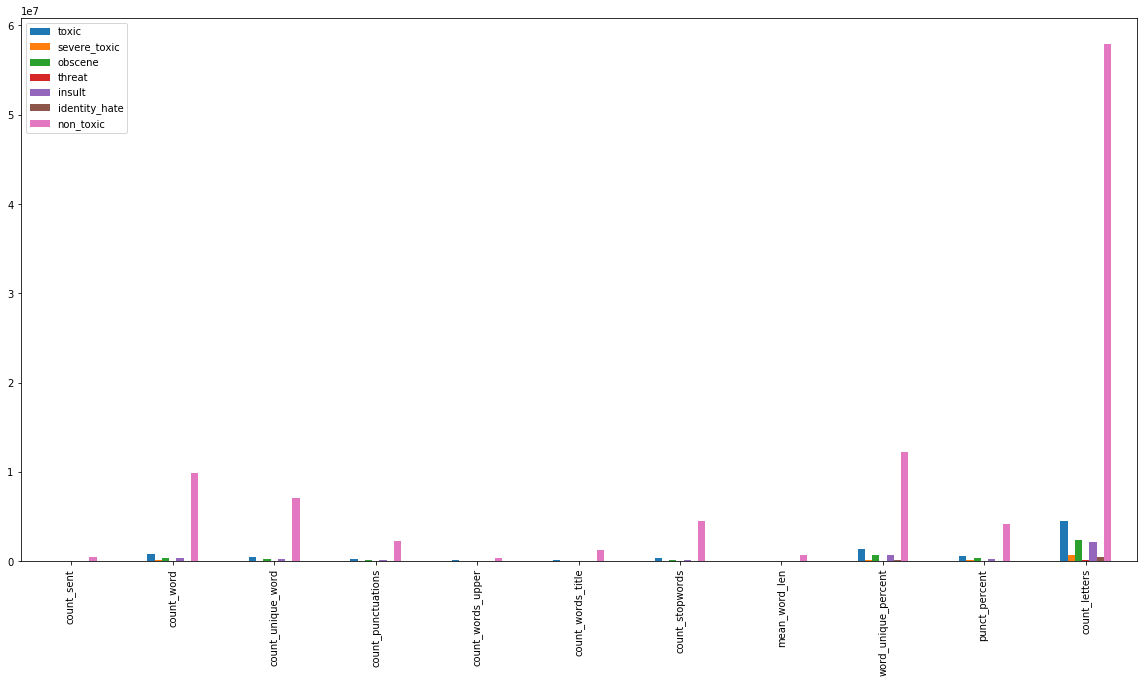

In [20]:
plot_df.plot(kind='bar',figsize=(20,10))
plt.show()

The numbers in the data are to big and its hard to interpert what is happening. The data needs to be normalized to get a better sense of the numbers.

In [21]:
normalized_df = ((plot_df-plot_df.min())/(plot_df.max()-plot_df.min()))
normalized_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
count_sent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003036
count_word,0.164294,0.157985,0.162738,0.169834,0.164163,0.158552,0.165668
count_unique_word,0.098227,0.038300,0.091804,0.080410,0.092950,0.083570,0.118059
count_punctuations,0.037809,0.055902,0.036397,0.079461,0.036708,0.026545,0.034117
count_words_upper,0.019785,0.064598,0.023507,0.048848,0.024413,0.031858,0.000000
count_words_title,0.008864,0.006150,0.007558,0.012267,0.007340,0.005286,0.016088
count_stopwords,0.062330,0.046094,0.058966,0.065750,0.060646,0.049893,0.071573
mean_word_len,0.006325,0.003040,0.005988,0.004103,0.006869,0.008447,0.006450
word_unique_percent,0.289111,0.172310,0.297770,0.266455,0.308950,0.273140,0.206331
punct_percent,0.123062,0.135567,0.120999,0.128137,0.125171,0.082823,0.066655


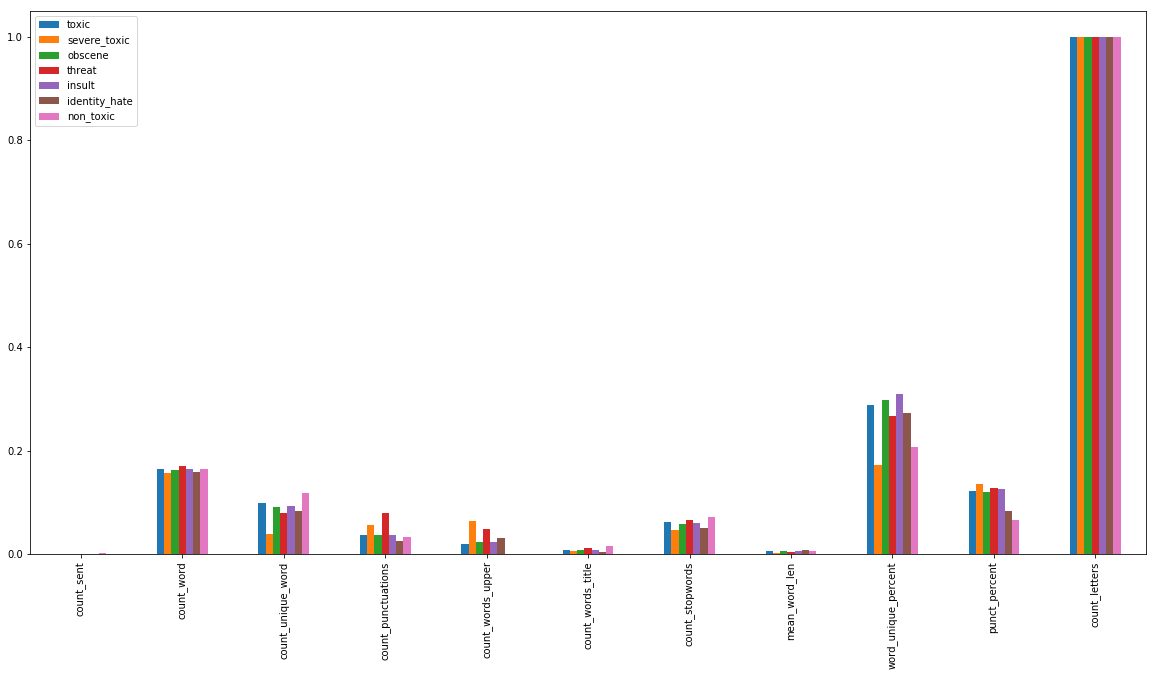

In [22]:
normalized_df.plot(kind='bar',figsize=(20,10))
plt.show()

It looks like the selected features is not indicative of being toxic. The amount of words or puntuation does not mean that you are more or less likely to be toxic.  

# <a name="clean"></a> Clean the Comments
---
In this section I need to clean the comments. This is done by splitting the comments into tokens that we can then lemmatize (or get the root of the word) followed by eliminating any stop words and non-alphabetic elements.

In [23]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm, tqdm_pandas, tqdm_notebook

lem = WordNetLemmatizer()
porter = PorterStemmer()
tqdm.pandas()

In [24]:
def clean_comment(text):
    
    #split into words
    tokens = word_tokenize(text)
    
    #change words to lower case and lemmatize
    lemmatized = [lem.lemmatize(word.lower()) for word in tokens]    
    
    #remove stop words
    words = [w for w in lemmatized if not w in eng_stopwords]
    
    #remove anything non-alphabetic
    clean_words = [word for word in words if word.isalpha()]
    
    #append to string
    clean_comment = " ".join(clean_words)
    
    return clean_comment

In [25]:
df.iloc[12235].comment_text

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [26]:
clean_comment(df.iloc[12235].comment_text)

'note read follow link reader see cited correctly link added subject vidkun ha added anotations make read oposite link show official line taken ugle trapped user peddle pov strangly mason quiet leaving defend factual truth thanks brother sitting blocking given'

In [27]:
df.comment_text = df.comment_text.progress_apply(lambda x: clean_comment(x))

100%|████████████████████████████████| 159571/159571 [01:58<00:00, 1348.21it/s]


## <a name="count"></a> Word Count
---
In this section I want to plot the word counts. However, the word used in the toxic comments are very graphic and vulgar so I will map the words with integers. If you wish to view the word count you can return **count_word** in the **get_top_n_words**
method.

In [28]:
from collections import Counter

In [29]:
#get the top n words
def get_top_n_words(comment_list, n, clean):
    wl=[]

    for comm in comment_list:
        for word in word_tokenize(comm):
            wl.append(word)
            
    
    count_word = dict(Counter(wl).most_common(n))

    if clean == True:
        return {list(count_word.values()).index(count)+1:count for count in list(count_word.values())}
    
    return count_word

In [30]:
#get a list of comments for each tag
clean_text = df[df.non_toxic == True].comment_text.values
toxic_text = df[df.toxic == True].comment_text.values
severe_toxic_text = df[df.severe_toxic == True].comment_text.values
obscene_text = df[df.obscene == True].comment_text.values
threat_text = df[df.threat == True].comment_text.values
insult_text = df[df.insult == True].comment_text.values
identity_hate_text = df[df.identity_hate == True].comment_text.values

In [31]:
#get the top used words for each tag
top_clean_words = get_top_n_words(clean_text, 10, False)
top_toxic_words = get_top_n_words(toxic_text, 5, True)
top_severe_toxic_words = get_top_n_words(severe_toxic_text, 5, True)
top_obscene_words = get_top_n_words(obscene_text, 5, True)
top_threat_words = get_top_n_words(threat_text, 5, True)
top_insult_words = get_top_n_words(insult_text, 5, True)
top_identity_hate_words = get_top_n_words(identity_hate_text, 5, True)

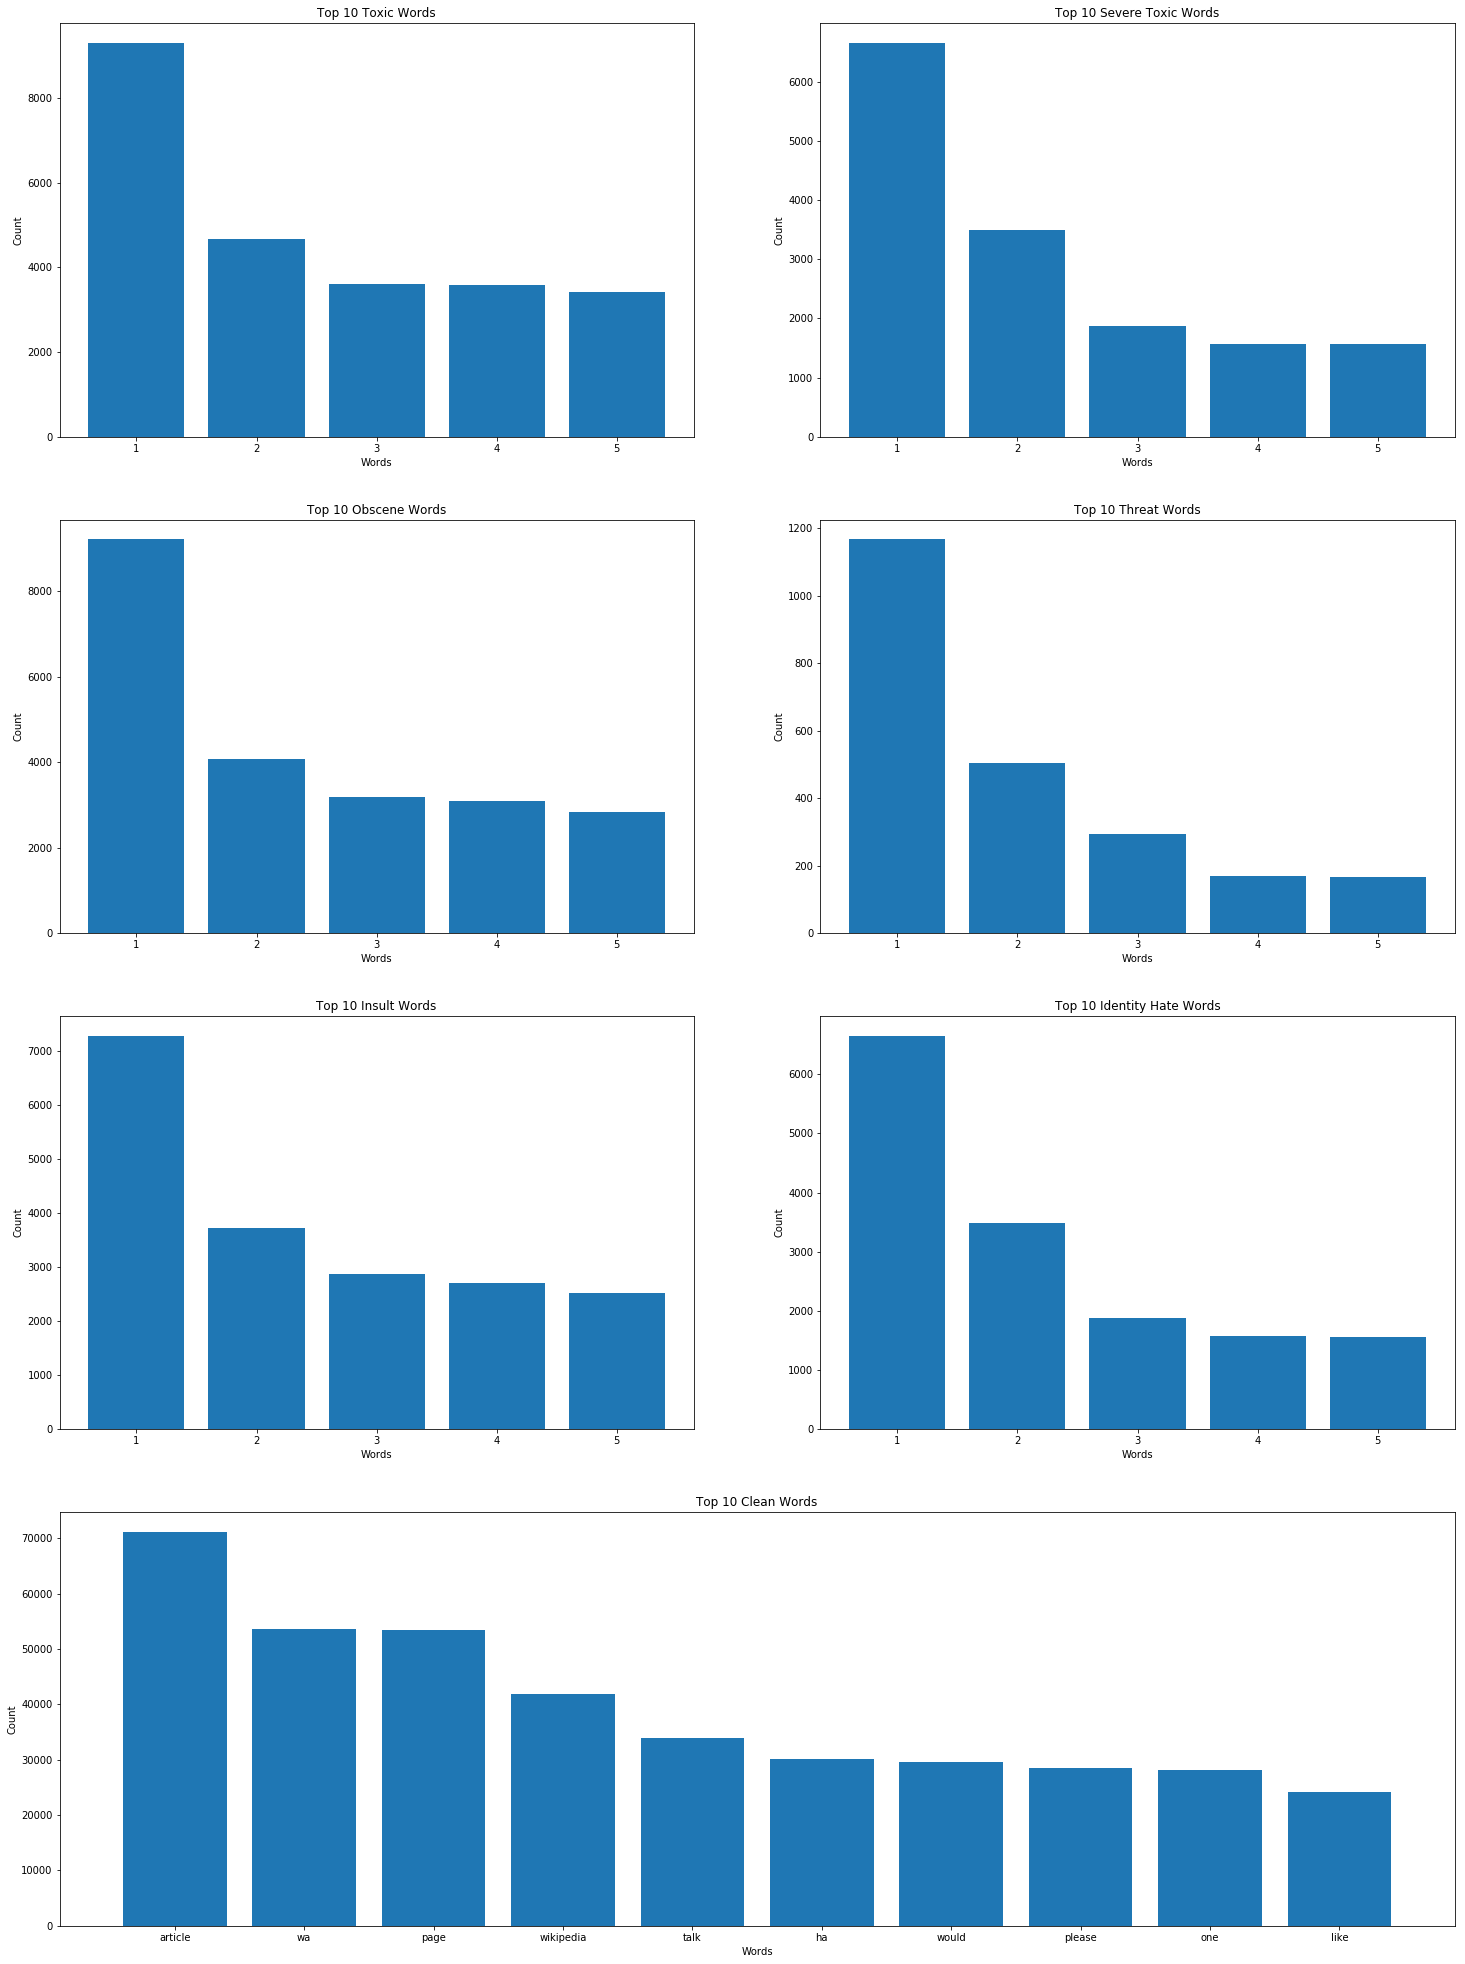

In [32]:
plt.figure(figsize=(25,35))

#plot the top 5 toxic words
plt.subplot(421)
plt.bar(top_toxic_words.keys(), top_toxic_words.values())
plt.title('Top 10 Toxic Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 5 severe toxic words
plt.subplot(422)
plt.bar(top_severe_toxic_words.keys(), top_severe_toxic_words.values())
plt.title('Top 10 Severe Toxic Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 5 obscene words
plt.subplot(423)
plt.bar(top_obscene_words.keys(), top_obscene_words.values())
plt.title('Top 10 Obscene Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 5 threat words
plt.subplot(424)
plt.bar(top_threat_words.keys(), top_threat_words.values())
plt.title('Top 10 Threat Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 5 insult words
plt.subplot(425)
plt.bar(top_insult_words.keys(), top_insult_words.values())
plt.title('Top 10 Insult Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 5 idenity hate words
plt.subplot(426)
plt.bar(top_severe_toxic_words.keys(), top_severe_toxic_words.values())
plt.title('Top 10 Identity Hate Words')
plt.ylabel('Count')
plt.xlabel('Words')

#plot the top 10 non toxic words
plt.subplot(414)
plt.bar(top_clean_words.keys(), top_clean_words.values())
plt.title('Top 10 Clean Words')
plt.ylabel('Count')
plt.xlabel('Words')


plt.show()

In [33]:
#df.to_csv(r'C:\Projects\Toxic-Comment-Classification\data\clean_data.csv')
#raise SystemExit("Stop right there!")

In [34]:
#import pandas as pd
#import numpy as np
#clean_df = pd.read_csv('data/clean_data.csv', index_col='id')
#df = clean_df
#df = clean_df.loc[np.random.choice(clean_df.index, size=2000)]

## <a name="wordcloud"></a>Word Frequency with Word Cloud

---
The word clouds been removed from this notebook as it contains some graphic and vulgar language. If you wish to view the word clouds copy the following code to a new cell and run it. The code snippet to display the word cloud with load into the cell and you can then rerun the cell to view the word clouds. 


%load snippets/wordcloud.py

# <a name="models"></a>Creating the model
---

In this section I will create several models that I will use to predict the classification of comments. One way to approach this is by consolidating the tags into one column by assigning an integer value from 1 to 7. However, to do this we first must eliminate any comments that have multiple tags.

## <a name="mnb"></a> Multinomial Naive Bayes
---
Naive Bayes is It is not necessarily the best model, however it is a good starting point when classifying text. 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

count_vectorizer = CountVectorizer(stop_words='english')

In [36]:
#remove any comment with multiple tags
cons_df = df[df.iloc[:,1:].sum(axis=1) == 1]

In [37]:
pd.set_option('mode.chained_assignment', None)

#Map the tag into a unique integer
cons_df['severe_toxic'] = cons_df['severe_toxic'].apply(lambda x: 2 if x == 1 else x)
cons_df['obscene'] = cons_df['obscene'].apply(lambda x: 3 if x == 1 else x)
cons_df['threat'] = cons_df['threat'].apply(lambda x: 4 if x == 1 else x)
cons_df['insult'] = cons_df['insult'].apply(lambda x: 5 if x == 1 else x)
cons_df['identity_hate'] = cons_df['identity_hate'].apply(lambda x: 6 if x == 1 else x)
cons_df['non_toxic'] = cons_df['non_toxic'].apply(lambda x: 7 if x == 1 else x)

#create one column with the classification
cons_df['classification'] = cons_df['toxic']+cons_df['severe_toxic']+cons_df['obscene']+cons_df['threat']+cons_df['insult']+cons_df['identity_hate']+cons_df['non_toxic']
cons_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,classification
id,,,,,,,,,
0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,7,7
000103f0d9cfb60f,match background colour seemingly stuck thanks...,0,0,0,0,0,0,7,7
000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,7,7
0001b41b1c6bb37e,ca make real suggestion improvement wondered s...,0,0,0,0,0,0,7,7
0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,7,7


In [38]:
y = cons_df['classification']
x = cons_df['comment_text']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=53)

In [39]:
#using the count vectorizer (bag of words)
count_train = count_vectorizer.fit_transform(X_train.values.astype('U'))
count_test = count_vectorizer.transform(X_test.values.astype('U'))

In [40]:
#create the classifier
nb_classifier = MultinomialNB()

# Fit the classifier 
nb_classifier.fit(count_train, y_train)

# Create the predicted tags
pred = nb_classifier.predict(count_test)

In [41]:
# Calculate the accuracy score
score = metrics.accuracy_score(y_test, pred)
print('Accuracy:',score)

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
print('\nConfusion Matrix:\n',cm)

Accuracy: 0.957371009857701

Confusion Matrix:
 [[  241     0     0     0     0  1637]
 [    7     0     0     0     0   106]
 [    1     0     0     0     0     7]
 [    8     0     0     0     0    87]
 [    0     0     0     0     0    15]
 [  234     3     1     0     0 47056]]


The accuracy of this model is really great, however the confusion matrix tells a different story. The accuracy score is misleading here because the data is imbalanced.

In a confusion matrix with multiple labels you the diagonal to have the number of correct predictions and everything else zero. This model has mislabeled everything as either toxic or non-toxic. The model is predicting poorly because when the comments with multiple tags were removed too many samples of non-toxic comments were removed.

To rectify this issue I will be using other multilabeling methods to predict the comments. 

## <a name="log"></a> Logistic Regression Pipeline
---
The first attempt to create a better model is to use logistic regression pipeline with a OneVsRestClassifier. 

For this and the following models the data size is too big (it will cause a memory error) to be able to get around this I will get a random sample of 5000 comments to create a train test split.  

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')

In [43]:
#creating a dataframe with a random sample of 5000 comments
reduced_df = df.loc[np.random.choice(df.index, size=5000)]

In [44]:
#create the input and output for the model
X = reduced_df.comment_text
y = reduced_df.drop(labels=['comment_text'], axis=1)

#create a train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, shuffle=True)

#fit our comments to tfidf vectorizer
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
tfidf_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

In [45]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

In [46]:
for category in list(df.columns.values[1:]):
    # Training logistic regression model on train data
    LogReg_pipeline.fit(tfidf_train, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(tfidf_test)
    score = float("{0:.4f}".format(metrics.accuracy_score(y_test[category], prediction)))
    
    print('{} accuracy: {}'.format(category, score))

toxic accuracy: 0.9153
severe_toxic accuracy: 0.99
obscene accuracy: 0.9473
threat accuracy: 0.9967
insult accuracy: 0.9507
identity_hate accuracy: 0.9907
non_toxic accuracy: 0.9073


## <a name="binary"></a>Binary Relevance
---
Binary relevance is arguably the most intuitive solution for learning from multi-label examples. It works by decomposing the multi-label learning task into a number of independent binary learning tasks (one per class label).

In [47]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

ModuleNotFoundError: No module named 'skmultilearn'

In [ ]:
# using binary relevance with a gaussian naive bayes base classifier
binary_classifier = BinaryRelevance(GaussianNB())

# train
binary_classifier.fit(tfidf_train, y_train)

# predict
predictions = binary_classifier.predict(tfidf_test)

# accuracy
print("Accuracy:{0:.4f}".format(metrics.accuracy_score(y_test,predictions)))

## <a name="chain"></a>Classifier Chains
---
The potential weakness of binary relevance is in ignoring correlations between labels. Classifier chains uses previous predictions of previous labels to predict labels in essence preserving the correlation between labels.

In [ ]:
from skmultilearn.problem_transform import ClassifierChain 

In [ ]:
# initialize classifier chains multi-label classifier
chain_classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
chain_classifier.fit(tfidf_train, y_train)

# predict
predictions = chain_classifier.predict(tfidf_test)

# accuracy
print("Accuracy:{0:.4f}".format(metrics.accuracy_score(y_test,predictions)))

# <a name="conclusion"></a>Conclusion
---

Being anonymous over the internet can sometimes make people say horrible things. Using a dataset that is from wiki corpus dataset which was rated by human raters for toxicity I was able to create several models to predict toxicity. The Classifier Chain model is the best performing model. This model will be published as an API to help sites classify their comments to validate toxicity and take the necessary measures.

Possible Future Work:
- Use LSTMs in deep learning.
- Diversify the data set (not just wikipedia comments)
    A lot of non-toxic comments refer to the actual article, i.e how to improve it
- Balance the dataset 

In [ ]:
raise SystemExit("Stop right there!")

## <a name="verify"></a>Verifying the model

In [ ]:
df.head()

In [ ]:
df.loc[['9d54e3b1059e33db']].comment_text

In [ ]:
txt = df.loc[['9d54e3b1059e33db', 'fc66ab1d86719f4b']].comment_text

In [ ]:
pred_text = chain_classifier.predict(tfidf_vectorizer.transform(txt))
print(pred_text.toarray().astype(int))

In [ ]:
pred_text.todense().astype(int)

In [ ]:
cons_df[['comment_text','classification']].head()

## <a name="export"></a>Exporting the model

In [ ]:
from sklearn.externals import joblib
joblib.dump(nb_classifier, 'api/model.pkl')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [ ]:
#preparing the final pipeline using the selected parameters
model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

In [ ]:
#fit model with training data
model.fit(X_train, y_train)
#evaluation on test data
pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(pred, y_test)

In [ ]:
joblib.dump(model, 'api/sample_model.pkl')